In [1]:
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
import pandas as pd
import os

from DataNamesReference import *
from Hyperparameters import *
from DataReformatters import *
from UtilityFuncs import evaluateModel
from ModelDefinition import fraudModel, NUM_OUTPUTS

import absl.logging as abslogging

In [2]:
%load_ext tensorboard

In [3]:
tf.get_logger().setLevel(abslogging.INFO)
# os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "1"

In [4]:
trainDataDf = pd.read_csv(TRAIN_DATA_PATH, **CSV_READ_ARGS)

In [5]:
#todo implement use of word2vec pretrained embedding matrix

trainTitleSequences = convertTitlesToPaddedSequences(trainDataDf)
trainLocationSequences = convertLocationsToPaddedSequences(trainDataDf)
trainDepartmentSequences = convertDepartmentsToPaddedSequences(trainDataDf)
trainCompanyProfileSequences = convertCompanyProfilesToPaddedSequences(trainDataDf)
trainDescriptionSequences = convertDescriptionsToPaddedSequences(trainDataDf)
trainRequirementsSequences = convertRequirementsToPaddedSequences(trainDataDf)
trainBenefitsSequences = convertBenefitsToPaddedSequences(trainDataDf)

In [6]:
posTrainExamples = trainDataDf[trainDataDf[FRAUDULENT_LABEL] == True]
numPosTrainExamples = posTrainExamples.shape[0]

numTrainExamples = trainDataDf.shape[0]

trainPosFrac = numPosTrainExamples/numTrainExamples

trainTelecommuting = trainDataDf[TELECOMMUTING_LABEL].astype("float32").to_numpy()
trainTelecommuting = np.reshape(trainTelecommuting, (numTrainExamples, 1))

trainHasLogo =  trainDataDf[HAS_LOGO_LABEL].astype("float32").to_numpy()
trainHasLogo = np.reshape(trainHasLogo, (numTrainExamples, 1))

trainHasQuestions =  trainDataDf[HAS_QUESTIONS_LABEL].astype("float32").to_numpy()
trainHasQuestions = np.reshape(trainHasQuestions, (numTrainExamples, 1))

trainLabels = trainDataDf[FRAUDULENT_LABEL].astype("int32").to_numpy()
trainLabels = np.reshape(trainLabels, (numTrainExamples,1))

In [7]:
#for each value of each categorical attribute, converting an index for a list of attribute values 
# into a vector of 0s with a 1 in that index's position
trainExamplesIndexArray = np.arange(numTrainExamples)

employmentTypesArray = trainDataDf[EMPLOYMENT_TYPE_LABEL].to_numpy()
employmentTypesTrainVectors = np.zeros((numTrainExamples, NUM_EMPLOYMENT_TYPE_OPTIONS), dtype="float32")
employmentTypesTrainVectors[trainExamplesIndexArray, employmentTypesArray] = 1

requiredExperienceArray = trainDataDf[REQUIRED_EXPERIENCE_LABEL].to_numpy()
requiredExperienceTrainVectors = np.zeros((numTrainExamples, NUM_REQUIRED_EXPERIENCE_OPTIONS), dtype="float32")
requiredExperienceTrainVectors[trainExamplesIndexArray, requiredExperienceArray] = 1

requiredEducationArray = trainDataDf[REQUIRED_EDUCATION_LABEL].to_numpy()
requiredEducationTrainVectors = np.zeros((numTrainExamples, NUM_REQUIRED_EDUCATION_OPTIONS), dtype="float32")
requiredEducationTrainVectors[trainExamplesIndexArray, requiredEducationArray] = 1

industryArray = trainDataDf[INDUSTRY_LABEL].to_numpy()
industryTrainVectors = np.zeros((numTrainExamples, NUM_INDUSTRY_OPTIONS), dtype="float32")
industryTrainVectors[trainExamplesIndexArray, industryArray] = 1

functionArray = trainDataDf[FUNCTION_LABEL].to_numpy()
functionTrainVectors = np.zeros((numTrainExamples, NUM_FUNCTION_OPTIONS), dtype="float32")
functionTrainVectors[trainExamplesIndexArray, functionArray] = 1


trainSalaryData = normalizeSalaryData(trainDataDf)

cutting outlier salary value(s) at index  6460  within a subset of the data
 min=  800000000.0 ; max=  1200000000.0 ; midpoint=  1000000000.0 ; range=  400000000.0
cutting outlier salary value(s) at index  6567  within a subset of the data
 min=  500000000.0 ; max=  800000000.0 ; midpoint=  650000000.0 ; range=  300000000.0
cutting outlier salary value(s) at index  6861  within a subset of the data
 min=  6000000.0 ; max=  7000000.0 ; midpoint=  6500000.0 ; range=  1000000.0
cutting outlier salary value(s) at index  6958  within a subset of the data
 min=  150000.0 ; max=  16500000.0 ; midpoint=  8325000.0 ; range=  16350000.0
cutting outlier salary value(s) at index  7031  within a subset of the data
 min=  120000.0 ; max=  15000000.0 ; midpoint=  7560000.0 ; range=  14880000.0
cutting outlier salary value(s) at index  9872  within a subset of the data
 min=  2000000.0 ; max=  15000000.0 ; midpoint=  8500000.0 ; range=  13000000.0


In [8]:
validDataDf = pd.read_csv(VALIDATION_DATA_PATH, **CSV_READ_ARGS)

In [9]:
validTitleSequences = convertTitlesToPaddedSequences(validDataDf)
validLocationSequences = convertLocationsToPaddedSequences(validDataDf)
validDepartmentSequences = convertDepartmentsToPaddedSequences(validDataDf)
validCompanyProfileSequences = convertCompanyProfilesToPaddedSequences(validDataDf)
validDescriptionSequences = convertDescriptionsToPaddedSequences(validDataDf)
validRequirementsSequences = convertRequirementsToPaddedSequences(validDataDf)
validBenefitsSequences = convertBenefitsToPaddedSequences(validDataDf)

In [10]:
posValidExamples = validDataDf[validDataDf[FRAUDULENT_LABEL] == True]
numPosValidExamples = posValidExamples.shape[0]

numValidExamples = validDataDf.shape[0]

validPosFrac = numPosValidExamples/numValidExamples

validTelecommuting =  validDataDf[TELECOMMUTING_LABEL].astype("float32").to_numpy()
validTelecommuting = np.reshape(validTelecommuting, (numValidExamples, 1))

validHasLogo =  validDataDf[HAS_LOGO_LABEL].astype("float32").to_numpy()
validHasLogo = np.reshape(validHasLogo, (numValidExamples, 1))

validHasQuestions =  validDataDf[HAS_QUESTIONS_LABEL].astype("float32").to_numpy()
validHasQuestions = np.reshape(validHasQuestions, (numValidExamples, 1))

validLabels = validDataDf[FRAUDULENT_LABEL].astype("int32").to_numpy()
validLabels = np.reshape(validLabels, (numValidExamples, 1))

In [11]:
#for each value of each categorical attribute, converting an index for a list of attribute values 
# into a vector of 0s with a 1 in that index's position
validExamplesIndexArray = np.arange(numValidExamples)

employmentTypesArray = validDataDf[EMPLOYMENT_TYPE_LABEL].to_numpy()
employmentTypesValidVectors = np.zeros((numValidExamples, NUM_EMPLOYMENT_TYPE_OPTIONS), dtype="float32")
employmentTypesValidVectors[validExamplesIndexArray, employmentTypesArray] = 1

requiredExperienceArray = validDataDf[REQUIRED_EXPERIENCE_LABEL].to_numpy()
requiredExperienceValidVectors = np.zeros((numValidExamples, NUM_REQUIRED_EXPERIENCE_OPTIONS), dtype="float32")
requiredExperienceValidVectors[validExamplesIndexArray, requiredExperienceArray] = 1

requiredEducationArray = validDataDf[REQUIRED_EDUCATION_LABEL].to_numpy()
requiredEducationValidVectors = np.zeros((numValidExamples, NUM_REQUIRED_EDUCATION_OPTIONS), dtype="float32")
requiredEducationValidVectors[validExamplesIndexArray, requiredEducationArray] = 1

industryArray = validDataDf[INDUSTRY_LABEL].to_numpy()
industryValidVectors = np.zeros((numValidExamples, NUM_INDUSTRY_OPTIONS), dtype="float32")
industryValidVectors[validExamplesIndexArray, industryArray] = 1

functionArray = validDataDf[FUNCTION_LABEL].to_numpy()
functionValidVectors = np.zeros((numValidExamples, NUM_FUNCTION_OPTIONS), dtype="float32")
functionValidVectors[validExamplesIndexArray, functionArray] = 1


validSalaryData = normalizeSalaryData(validDataDf)

cutting outlier salary value(s) at index  513  within a subset of the data
 min=  6266624.0 ; max=  8582080.0 ; midpoint=  7424352.0 ; range=  2315456.0


In [13]:
#todo experiment with more weight on primary prediction
MAIN_PRED_WEIGHT=0.65
DESCRIPTION_SIDE_PRED_WEIGHT=0.05
TITLE_SIDE_PRED_WEIGHT=0.05
LOCATION_SIDE_PRED_WEIGHT=0.05
DEPARTMENT_SIDE_PRED_WEIGHT=0.05
COMPANY_PROFILE_SIDE_PRED_WEIGHT=0.05
REQUIREMENTS_SIDE_PRED_WEIGHT=0.05
BENEFITS_SIDE_PRED_WEIGHT=0.05

predictionLossWeights = [MAIN_PRED_WEIGHT, DESCRIPTION_SIDE_PRED_WEIGHT, TITLE_SIDE_PRED_WEIGHT, 
                         LOCATION_SIDE_PRED_WEIGHT, DEPARTMENT_SIDE_PRED_WEIGHT,
                        COMPANY_PROFILE_SIDE_PRED_WEIGHT, REQUIREMENTS_SIDE_PRED_WEIGHT, BENEFITS_SIDE_PRED_WEIGHT]

fraudOptimizer = optimizers.Nadam(learning_rate=LEARNING_RATE)

fraudModel.compile(loss=["binary_crossentropy"]*NUM_OUTPUTS, loss_weights=predictionLossWeights, 
                   optimizer=fraudOptimizer,
                   metrics=[metrics.AUC()])
print(fraudModel.summary())

# from tensorflow.keras.utils import plot_model
# plot_model(fraudModel, to_file="model_visualisation.png")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
descriptionTextInput (InputLaye [(None, 301)]        0                                            
__________________________________________________________________________________________________
titleTextInput (InputLayer)     [(None, 9)]          0                                            
__________________________________________________________________________________________________
locationTextInput (InputLayer)  [(None, 6)]          0                                            
__________________________________________________________________________________________________
departmentTextInput (InputLayer [(None, 4)]          0                                            
______________________________________________________________________________________________

In [14]:
CHECKPOINT_NAME_FORMAT="weights_after_{epoch:02d}-val_loss{val_loss:.4f}.hdf5"
checkpointFilePath = os.path.join(CHECKPOINT_DIR_PATH, CHECKPOINT_NAME_FORMAT)
checkpointer = callbacks.ModelCheckpoint(filepath=checkpointFilePath, save_best_only=True)
earlyStopper = callbacks.EarlyStopping(monitor=EARLY_STOPPING_MONITOR, mode=EARLY_STOPPING_MODE,
                                       patience=EARLY_STOPPING_PATIENCE, verbose=1, min_delta=1e-9,
                                       restore_best_weights=True)

tboardLogName = datetime.now().strftime("%Y%m%d-%H%M%S")
tboardLogPath = os.path.join(TENSORBOARD_DIR_PATH, tboardLogName)
tboardCallback = callbacks.TensorBoard(log_dir=tboardLogPath)


#todo knockout test whether this actually helps auc
trainClassWeights = {0:1, 1:1/trainPosFrac}

trainInputs = [
    employmentTypesTrainVectors, requiredExperienceTrainVectors, requiredEducationTrainVectors,
    industryTrainVectors, functionTrainVectors, trainTelecommuting, trainHasLogo, trainHasQuestions, trainSalaryData,
    trainDescriptionSequences, trainTitleSequences, trainLocationSequences, trainDepartmentSequences ,
    trainCompanyProfileSequences, trainRequirementsSequences, trainBenefitsSequences]

validInputs= [
    employmentTypesValidVectors, requiredExperienceValidVectors, requiredEducationValidVectors, industryValidVectors,
      functionValidVectors, validTelecommuting, validHasLogo, validHasQuestions, validSalaryData,
      validDescriptionSequences, validTitleSequences, validLocationSequences, validDepartmentSequences,
      validCompanyProfileSequences, validRequirementsSequences, validBenefitsSequences]

In [15]:
trainHist = fraudModel.fit(trainInputs, [trainLabels]*NUM_OUTPUTS,
    class_weight=[trainClassWeights]*NUM_OUTPUTS, verbose=1,
    validation_data=(validInputs, [validLabels]*NUM_OUTPUTS),
    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
    callbacks=[earlyStopper, checkpointer, tboardCallback])

c:\users\ssili\pycharmprojects\jobpostingfrauddetection\venv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\ssili\pycharmprojects\jobpostingfrauddetection\venv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


In [16]:
validPredictionOutputs = fraudModel.predict(validInputs)
validPreds = validPredictionOutputs[0]

on  validation  data, the  comprehensive neural network model  achieved:
 accuracy=  0.8937360178970917 ; balanced accuracy =  0.8930582348685797 
F1 score=  0.448742746615087 ; AUROC score=  0.953602001446829 
Precision=  0.2997416020671835 ; Recall=  0.8923076923076924
Area under ROC curve (should equal AUROC score above):  0.953602001446829


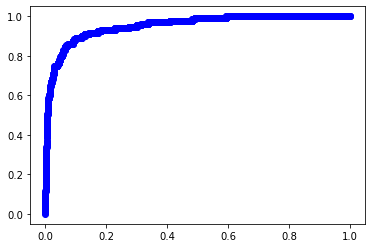

In [17]:
evaluateModel("comprehensive neural network model", "validation", validLabels, validPreds)